# Analysis of Benchmarking results in R

In [ ]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(dplyr)
    library(data.table)
    library(bench)
})

In [47]:
# load and rowbind all benchmarking data
files <- list.files("results", pattern = "\\.csv$", full.names = TRUE)
all_data <- lapply(files, function(file) {
    fread(file, data.table = FALSE) %>%
        mutate(tool = tools::file_path_sans_ext(basename(file)))
}) %>%
    bind_rows() %>%
    relocate(tool) %>%
    mutate(tool = as.factor(tool), mem_alloc = as_bench_bytes(mem_alloc)) %>%
    mutate(across(where(is.character), bench::as_bench_time))

print(levels(all_data$tool))
print(dim(all_data))
head(all_data)

[1] "scRepertoire2"
[1] 10 22


,tool,dataset_size,min,median,mean,max,sd,ci95,mem_alloc,num_gc,⋯,gc0_min,gc0_max,gc1_mean,gc1_median,gc1_min,gc1_max,gc2_mean,gc2_median,gc2_min,gc2_max
,<fct>,<int>,<bch:tm>,<bch:tm>,<bch:tm>,<bch:tm>,<bch:tm>,<bch:tm>,<bch:byt>,<int>,⋯,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,scRepertoire2,1000,93.9ms,111ms,130ms,221ms,39.4ms,22.8ms,11.4MB,2,⋯,0,1,0.0,0,0,0,0.0,0,0,0
2,scRepertoire2,3000,239ms,259ms,301ms,361ms,44.6ms,25.8ms,32MB,5,⋯,0,1,0.1,0,0,1,0.0,0,0,0
3,scRepertoire2,6000,340ms,392ms,622ms,2.41s,629ms,364ms,64MB,8,⋯,0,1,0.1,0,0,1,0.1,0,0,1
4,scRepertoire2,10000,607ms,607ms,809ms,1.98s,414ms,240ms,109MB,11,⋯,0,1,0.1,0,0,1,0.1,0,0,1
5,scRepertoire2,30000,1.75s,2.02s,2.41s,3.23s,616ms,357ms,304MB,32,⋯,1,3,0.8,1,0,2,0.4,0,0,1
6,scRepertoire2,60000,3.89s,5.18s,5.06s,5.64s,498ms,289ms,595MB,54,⋯,2,5,1.4,1,0,3,0.8,1,0,1


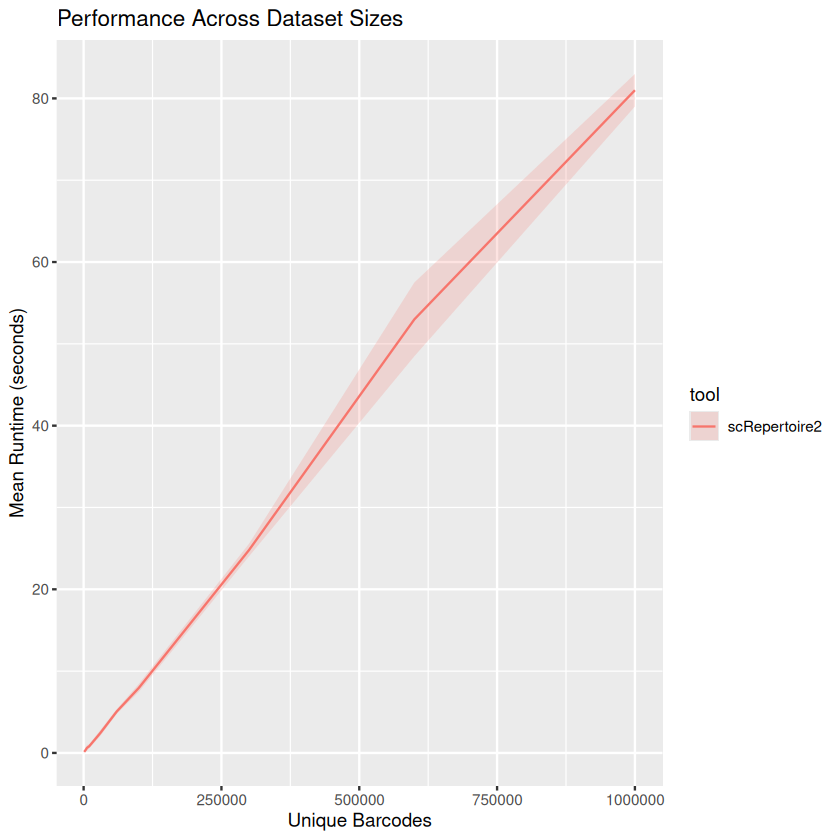

In [48]:
ggplot(all_data, aes(x = dataset_size, y = mean, color = tool, fill = tool)) +
  geom_line() +
  geom_ribbon(aes(ymin = mean - ci95, ymax = mean + ci95), alpha = 0.2, color = NA) +
  labs(x = "Unique Barcodes", y = "Mean Runtime (seconds)", title = "Performance Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")

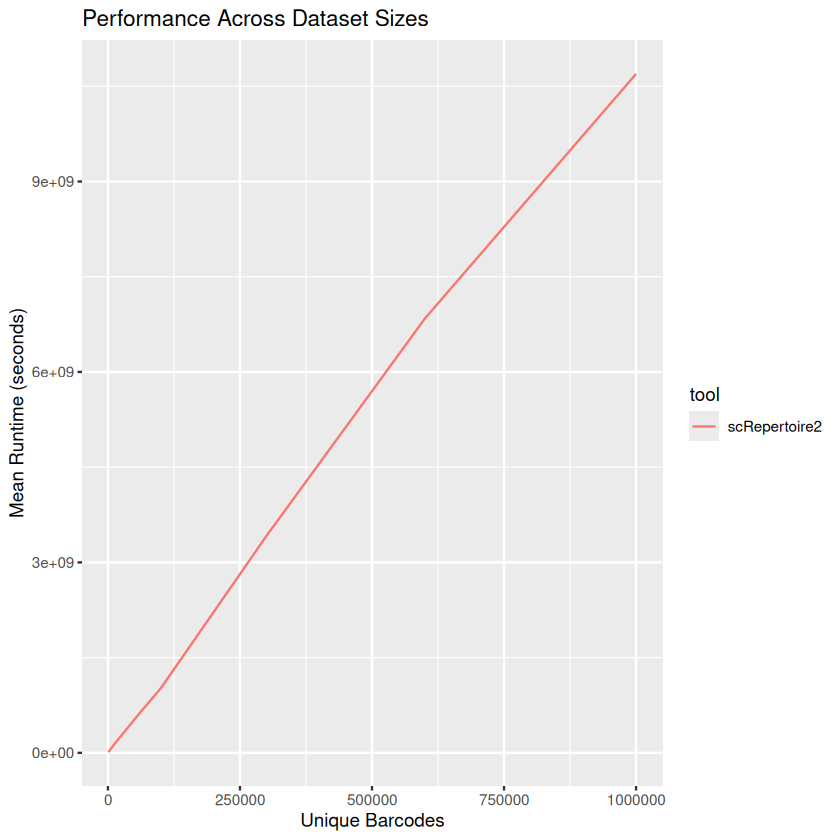

In [49]:
ggplot(all_data, aes(x = dataset_size, y = mem_alloc, color = tool, fill = tool)) +
  geom_line() +
  labs(x = "Unique Barcodes", y = "Mean Runtime (seconds)", title = "Performance Across Dataset Sizes") +
  scale_y_continuous(trans = "identity")